# Import necessary libraries

In [1]:
import pandas as pd
import numpy as np
import torch
import string
import re
import matplotlib.pyplot as plt
from scipy.spatial.distance import cosine

from transformers import BertTokenizer, BertModel
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased', output_hidden_states=True)
model.eval()

from sentence_transformers import SentenceTransformer
s_model = SentenceTransformer('bert-base-nli-stsb-mean-tokens')

C:\Users\Savannah\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\Savannah\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\Savannah\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\Savannah\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:529: FutureWa

# Load survey data

In [2]:
# Read it in
path = "../data/surveys_clean.csv"
df = pd.read_csv(path, na_filter=False)

# Drop unnecessary columns
df.drop(columns=['ind_id', 'subject_id', 'image_name', 'image_name_2', 'index'], inplace=True)

# Filter by topic

In [3]:
def get_token_embeddings(text):
    
    # Tokenize the text
    split_text = text.split(". ")
    marked_text = "[CLS] " + " [SEP] ".join(split_text) + " [SEP]"
    tokenized_text = tokenizer.tokenize(marked_text)[:512] # Truncate if longer than 512
    indexed_tokens = tokenizer.convert_tokens_to_ids(tokenized_text)

    # Mark tokens belonging to a sentence
    segment_ids = [0]*len(tokenized_text)
    is_zero = True
    for i in range(len(tokenized_text)):
        segment_ids[i] = 0 if is_zero else 1
        if tokenized_text[i] == "[SEP]":
            is_zero = not is_zero

    # Convert to torch tensors
    tokens_tensor = torch.tensor([indexed_tokens])
    segments_tensors = torch.tensor([segment_ids])

    # Run through BERT
    with torch.no_grad():
        outputs = model(tokens_tensor, segments_tensors)
        hidden_states = outputs[2]

    # Adjust
    token_embeddings = torch.stack(hidden_states, dim=0)
    token_embeddings = torch.squeeze(token_embeddings, dim=1)
    token_embeddings = token_embeddings.permute(1,0,2)

    # Get token vectors
    token_vecs_sum = []
    for token in token_embeddings:
        sum_vec = torch.sum(token[-4:], dim=0)
        token_vecs_sum.append(sum_vec)
    
    return token_vecs_sum

## Build dictionary

In [4]:
# Use keyword in a short sentence/phrase for context
# NOTE: Pre-check the tokenization of each phrase.
#       Set 'idx' to the index of the keyword in the list of tokens
keywords = [
    {"text": "The white man", "idx": 2, "embed": None},
    {"text": "The negro man", "idx": 2, "embed": None}
]

for k in keywords:
    embed = get_token_embeddings(k['text'])
    k['embed'] = embed[k['idx']]

## Search responses for tokens similar to keywords

In [5]:
# Create new column for tracking relevant responses
df['about_race'] = 0

for i in range(len(df)):
    embed = get_token_embeddings(df['long'][i])
    for j in range(len(embed)): # for e in len(embed)
        for k in keywords:
            sim = 1 - cosine(embed[j], k['embed'])
            if sim >= 0.5:
                df.at[i, 'about_race'] += 1
                break
    if i%100==0:
        print(i)

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700


# Embed responses

In [6]:
# Select responses categorized as "about race"
df_race = df[df['about_race'] > 0]

# Group by race
df_race_black = df_race[df_race['racial_group'] == "black"]
df_race_white = df_race[df_race['racial_group'] == "white"]

# Get long responses
res_race_black = df_race_black['long'].tolist()
res_race_white = df_race_white['long'].tolist()
res_race = res_race_black + res_race_white

## Method 1: Use entire response

In [7]:
# Transpose so each column is one response embedding
embed_race_black = np.transpose(s_model.encode(res_race_black))
embed_race_white = np.transpose(s_model.encode(res_race_white))
embed_race = np.concatenate((embed_race_black, embed_race_white), axis=1)

### Singular Values

In [8]:
def plot_singular_values():
    
    for A in [embed_race_black, embed_race_white, embed_race]:
        U,S,Vt = np.linalg.svd(A, full_matrices=False)
        S = [S[i]/S[0] for i in range(len(S))]
        plt.semilogy(S)
    plt.legend(["Black Responses", "White Responses", "All Responses"])
    plt.title("Singular values of matrix of embeddings of long responses categorized as 'about race'")
    
    plt.figure()
    
    for A in [embed_race_black, embed_race_white]:
        U,S,Vt = np.linalg.svd(A, full_matrices=False)
        S = [S[i]/S[0] for i in range(len(S))]
        plt.semilogy(S)
    plt.legend(["Black Responses", "White Responses"])
    plt.title("Singular values of matrix of embeddings of long responses categorized as 'about race'")

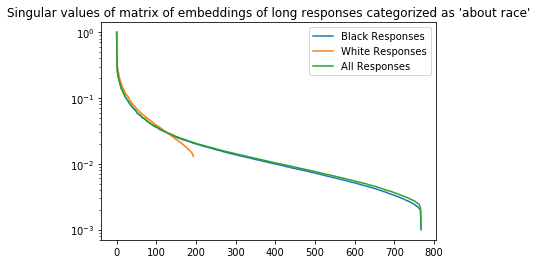

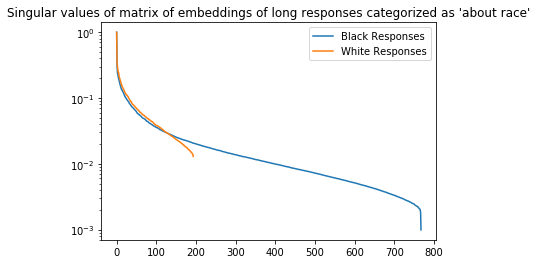

In [9]:
plot_singular_values()

### CUR Decomposition

In [45]:
def cur(A, idx=False, SVD=None, rank=None, p_C=[], p_R=[]):
    
    if SVD==None:
        SVD = np.linalg.svd(A, full_matrices=False)
    if rank==None:
        rank = np.linalg.matrix_rank(A)
    
    V,S,Wt = SVD
    
    def DEIM(M, p=[]): # row/column selection
        if not p:
            p.append(np.argmax(np.abs(M[:,0]))) # row index of the largest value in the first column of M
        for i in range(len(p),rank):
            res = M[:,i] - np.dot(M[:,:i],np.dot(np.linalg.inv(M[:,:i][p]), M[:,i][p]))
            p.append(np.argmax(np.abs(res)))
        return p
    
    p_C = DEIM(np.transpose(Wt), p_C)
    C = A[:,p_C]
    
    #p_R = DEIM(V)
    #R = A[p_R]
    
    #U = np.linalg.pinv(C) @ A @ np.linalg.pinv(R)
    
    return (C,p_C) if idx else C
    #return (C,U,R, p_C, p_R) if idx else (C,U,R)

In [11]:
C_race, p_C_race = cur(embed_race, idx=True)

### Are responses with more sentences given priority?

(array([58., 17., 14.,  3.,  4.,  0.,  3.,  0.,  0.,  1.]),
 array([ 1. ,  2.5,  4. ,  5.5,  7. ,  8.5, 10. , 11.5, 13. , 14.5, 16. ]),
 <a list of 10 Patch objects>)

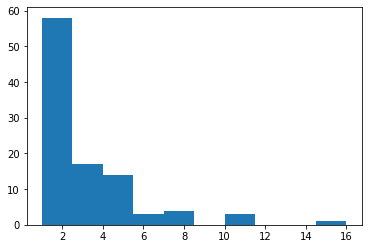

In [12]:
# Distribution of number of sentences in first 100 responses chosen by DEIM-CUR
lengths = [len(res_race[i].split(". ")) for i in p_C_race[:100]]
plt.hist(lengths)

### Error Plots

In [39]:
def plot_eta_c(A):
    V,S,Wt = np.linalg.svd(A, full_matrices=False)
    rank = np.linalg.matrix_rank(A)
    
    eta_c = np.zeros(rank)
    norm = np.zeros(rank)
    sig = np.zeros(rank)
    
    p_C_k = []
    
    A_k = np.zeros(A.shape)
    for k in range(rank):
        SVD_k = (V[:,:k+1],S[:k+1],Wt[:k+1,:])
        A_k = (SVD_k[0] * SVD_k[1][...,None,:]) @ SVD_k[2]
        C_k, p_C_k = cur(A_k, idx=True, SVD=SVD_k, rank=k+1, p_C=p_C_k)
        
        WtF_k = SVD_k[2][:k+1,:][:,p_C_k[:k+1]]
        eta_c[k] = np.linalg.norm(np.linalg.inv(WtF_k))
        
        X_k = np.linalg.pinv(C_k) @ A
        norm[k] = np.linalg.norm(A - C_k@X_k)
        
        sig[k] = np.linalg.norm(A - (SVD_k[0] * SVD_k[1][...,None,:]) @ SVD_k[2])
        
        if k%100==0:
            print(k)
        
    plt.scatter(range(rank), eta_c)
    plt.scatter(range(rank), norm)
    plt.scatter(range(1,rank+1), sig, marker='o', facecolors='none', edgecolors='r')
    
    plt.xlabel('k')
    plt.legend(["(eta_c)_k", "|| A - C_k(X_k) ||", "sigma_k"])

0
100
200
300
400
500
600
700


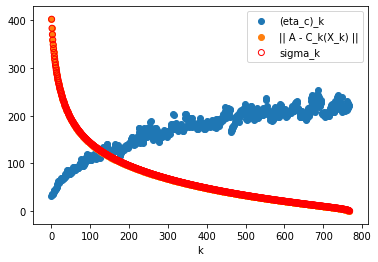

In [14]:
plot_eta_c(embed_race)

## Method 2: Average the embeddings of each sentence

In [15]:
res_race_black_split = [r.split(". ") for r in res_race_black]
embed_race_black = np.transpose([
    np.sum(s_model.encode(r), axis=0) / len(r)
    for r in res_race_black_split
])

res_race_white_split = [r.split(". ") for r in res_race_white]
embed_race_white = np.transpose([
    np.sum(s_model.encode(r), axis=0) / len(r)
    for r in res_race_white_split
])

embed_race = np.concatenate((embed_race_black, embed_race_white), axis=1)

### Singular values

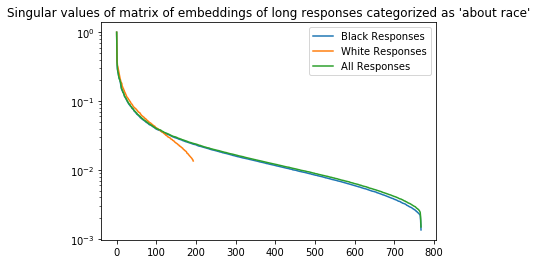

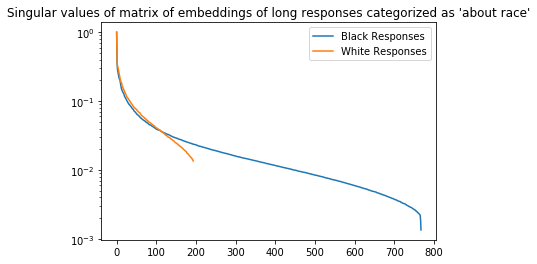

In [16]:
plot_singular_values()

### CUR Decomposition

In [17]:
C_race, p_C_race = cur(embed_race, idx=True)

### Are responses with more sentences given priority?

(array([96.,  2.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  1.]),
 array([ 1. ,  2.1,  3.2,  4.3,  5.4,  6.5,  7.6,  8.7,  9.8, 10.9, 12. ]),
 <a list of 10 Patch objects>)

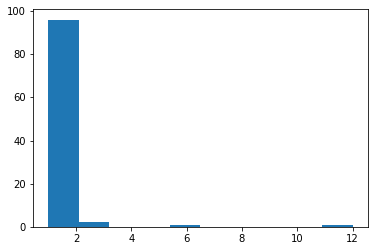

In [18]:
lengths = [len(res_race[i].split(". ")) for i in p_C_race[:100]]
plt.hist(lengths)

### Error Plots

0
100
200
300
400
500
600
700


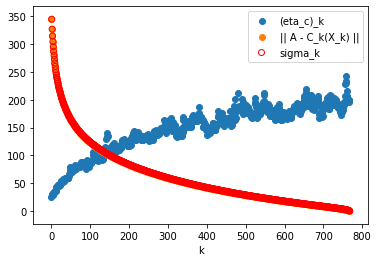

In [19]:
plot_eta_c(embed_race)

## Method 3: Treat each sentence as separate response

In [20]:
# Split responses into sentences
res_race_black_split = [
    # remove leading/trailing whitespace from r
    # split sentences of r at punctuation
    # remove empty strings resulting from regex
    list(filter(None, re.split("[.?!]", r.strip())))
    for r in res_race_black
]

res_race_white_split = [
    list(filter(None, re.split("[.?!]", r.strip())))
    for r in res_race_white
]

# Flatten, storing original indices
res_race_black_split_flat = []
for i in range(len(res_race_black_split)):
    for s in res_race_black_split[i]:
        res_race_black_split_flat.append((i,s))
        
res_race_white_split_flat = []
for i in range(len(res_race_white_split)):
    for s in res_race_white_split[i]:
        res_race_white_split_flat.append((i+len(res_race_black),s))
        
res_race_split_flat = res_race_black_split_flat + res_race_white_split_flat

# Embed
embed_race_black = np.transpose(
    s_model.encode(
        [r[1] for r in res_race_black_split_flat]
    )
)

embed_race_white = np.transpose(
    s_model.encode(
        [r[1] for r in res_race_white_split_flat]
    )
)

embed_race = np.concatenate((embed_race_black, embed_race_white), axis=1)

### Singular values

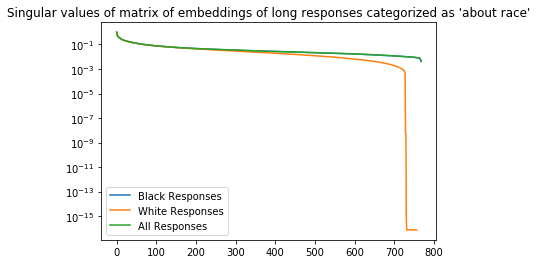

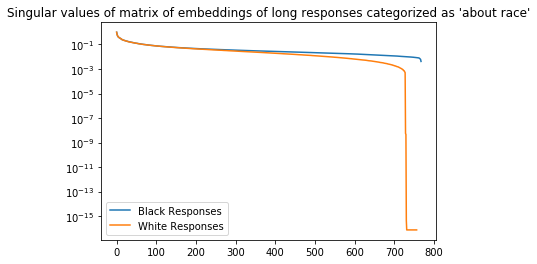

In [21]:
plot_singular_values()

### CUR Decomposition

In [22]:
C_race, p_C_race = cur(embed_race, idx=True)

### Are responses with more sentences given priority?

(array([11., 14., 33., 14., 12., 10.,  2.,  3.,  0.,  1.]),
 array([ 1. ,  3.4,  5.8,  8.2, 10.6, 13. , 15.4, 17.8, 20.2, 22.6, 25. ]),
 <a list of 10 Patch objects>)

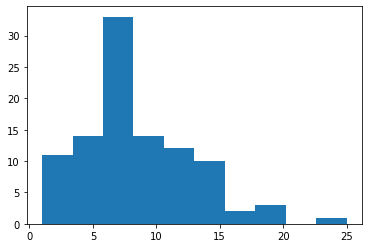

In [25]:
lengths = [len(res_race[res_race_split_flat[i][0]].split(". ")) for i in p_C_race[:100]]
plt.hist(lengths)

### Error plots

In [47]:
plot_eta_c(embed_race)

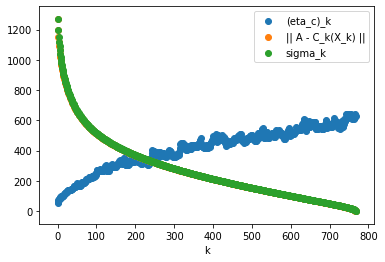

## Method 4: Use the embeddings of the first 5 sentences as one large vector

In [29]:
def embed_5(r):
    embed_5 = []
    if len(r) == 1:
        embed_5 = s_model.encode(r*5)
    elif len(r) == 2:
        embed_5 = s_model.encode(r*2 + r[:1])
    elif len(r) == 3:
        embed_5 = s_model.encode(r + r[:2])
    elif len(r) == 4:
        embed_5 = s_model.encode(r + r[:1])
    else:
        embed_5 = s_model.encode(r[:5])
    return [item for sublist in embed_5 for item in sublist]

res_race_black_split = [r.split(". ") for r in res_race_black]
res_race_white_split = [r.split(". ") for r in res_race_white]

embed_race_black = np.transpose([embed_5(r) for r in res_race_black_split])
embed_race_white = np.transpose([embed_5(r) for r in res_race_white_split])

embed_race = np.concatenate((embed_race_black, embed_race_white), axis=1)

### Singular values

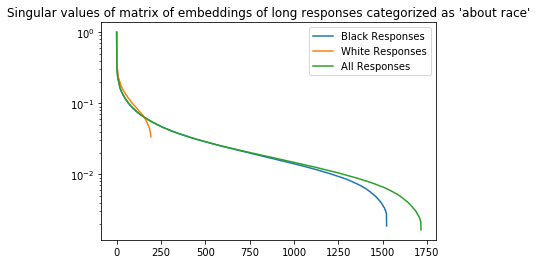

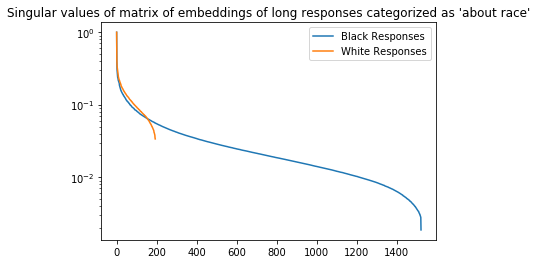

In [30]:
plot_singular_values()

### CUR Decomposition

In [31]:
C_race, p_C_race = cur(embed_race, idx=True)

### Are responses with more sentences given priority?

(array([28., 20., 21.,  9.,  9.,  5.,  4.,  1.,  1.,  2.]),
 array([ 1. ,  2.7,  4.4,  6.1,  7.8,  9.5, 11.2, 12.9, 14.6, 16.3, 18. ]),
 <a list of 10 Patch objects>)

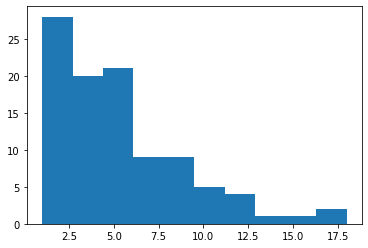

In [32]:
lengths = [len(res_race[i].split(". ")) for i in p_C_race[:100]]
plt.hist(lengths)

### Error plots

In [ ]:
plot_eta_c(embed_race)

0
100
200
300
400
500
600
700
800
900
